In [1]:
# for database and dataframe
import sqlite3
import pandas as pd

# for plotting and processing
from tqdm import tqdm
import matplotlib.pyplot as plt

# utils for I/O with database
import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.utils import *
from src.approximation import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

In [2]:
# For ML part
import torch
import numpy as np
print("GPU connected: ", torch.cuda.is_available())
torch.cuda.empty_cache()

import torch
# mac neural engine
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
    x = torch.ones(1, device=device)
    print (x)
# cuda device
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("Neither MPS device nor CUDA devices available.")

GPU connected:  False
Using MPS
tensor([1.], device='mps:0')


In [35]:
torch.device('cuda' if torch.cuda.is_available() else 'mps' if  torch.backends.mps.is_available() else 'cpu')

device(type='mps')

# Load dataframe from database

In [24]:
# specify system parameters
params = {
    'N': 10000, # number of nodes
    'K': 100, # number of connections per node
    'mu': 0.2, # fraction of nodes that receive input
    'seed': 1001 # random seed
}

In [26]:
con = sqlite3.connect('./simulations.db')
simulations= pd.read_sql_query("SELECT * from simulations", con)
beta_approximations = pd.read_sql_query("SELECT * from beta_approximations", con)
con.close()
print(simulations.head())

   simulation_id      N    K  lambda   mu    h       window  seed  \
0              1  10000  100     0.0  0.2  1.0     0.000001  1001   
1              2  10000  100     0.0  0.2  1.0     1.000000  1001   
2              3  10000  100     0.0  0.2  1.0    10.000000  1001   
3              4  10000  100     0.0  0.2  1.0   100.000000  1001   
4              5  10000  100     0.0  0.2  1.0  1000.000000  1001   

                                            raw_file         dataset  
0  /scratch02.local/johannes/projects/sahel_finit...   samples/1e-06  
1  /scratch02.local/johannes/projects/sahel_finit...     samples/1.0  
2  /scratch02.local/johannes/projects/sahel_finit...    samples/10.0  
3  /scratch02.local/johannes/projects/sahel_finit...   samples/100.0  
4  /scratch02.local/johannes/projects/sahel_finit...  samples/1000.0  


In [28]:
# select simulations with the specified parameters
simulations = simulations[(simulations['N'] == params['N']) & (simulations['K'] == params['K']) & (simulations['mu'] == params['mu']) & (simulations['seed'] == params['seed'])]
# drop constant columns
simulations = simulations.drop(columns=['seed', 'N', 'K', 'mu'])
# simulation_id is the unique identifier for each simulation and identifyer in beta_approximations
beta_approximations = beta_approximations[beta_approximations['simulation_id'].isin(simulations['simulation_id'])]
print(simulations)

      simulation_id  lambda             h        window  \
0                 1  0.0000  1.000000e+00      0.000001   
1                 2  0.0000  1.000000e+00      1.000000   
2                 3  0.0000  1.000000e+00     10.000000   
3                 4  0.0000  1.000000e+00    100.000000   
4                 5  0.0000  1.000000e+00   1000.000000   
...             ...     ...           ...           ...   
3157           3158  0.9999  5.623413e-07      1.000000   
3158           3159  0.9999  5.623413e-07     10.000000   
3159           3160  0.9999  5.623413e-07    100.000000   
3160           3161  0.9999  5.623413e-07   1000.000000   
3161           3162  0.9999  5.623413e-07  10000.000000   

                                               raw_file          dataset  
0     /scratch02.local/johannes/projects/sahel_finit...    samples/1e-06  
1     /scratch02.local/johannes/projects/sahel_finit...      samples/1.0  
2     /scratch02.local/johannes/projects/sahel_finit...     sample

In [29]:
# merge the two dataframes according to simulation_id (which only keeps the ones where analysis was done so far!!)
df = pd.merge(simulations, beta_approximations, on='simulation_id')
df

,simulation_id,lambda,h,window,raw_file,dataset,a,b,loc,scale
0,1,0.0000,1.000000e+00,0.000001,/scratch02.local/johannes/projects/sahel_finit...,samples/1e-06,3.000801e+03,2.072159e+04,-0.0001,1.0002
1,2,0.0000,1.000000e+00,1.000000,/scratch02.local/johannes/projects/sahel_finit...,samples/1.0,6.499563e+03,4.488178e+04,-0.0001,1.0002
2,3,0.0000,1.000000e+00,10.000000,/scratch02.local/johannes/projects/sahel_finit...,samples/10.0,5.995206e+04,4.139902e+05,-0.0001,1.0002
3,4,0.0000,1.000000e+00,100.000000,/scratch02.local/johannes/projects/sahel_finit...,samples/100.0,5.947034e+05,4.106638e+06,-0.0001,1.0002
4,5,0.0000,1.000000e+00,1000.000000,/scratch02.local/johannes/projects/sahel_finit...,samples/1000.0,5.693645e+06,3.931665e+07,-0.0001,1.0002
...,...,...,...,...,...,...,...,...,...,...
3157,3158,0.9999,5.623413e-07,1.000000,/scratch02.local/johannes/projects/sahel_finit...,samples/1.0,2.826496e-01,2.242160e+02,-0.0001,1.0002
3158,3159,0.9999,5.623413e-07,10.000000,/scratch02.local/johannes/projects/sahel_finit...,samples/10.0,2.830932e-01,2.246287e+02,-0.0001,1.0002
3159,3160,0.9999,5.623413e-07,100.000000,/scratch02.local/johannes/projects/sahel_finit...,samples/100.0,2.857805e-01,2.274708e+02,-0.0001,1.0002
3160,3161,0.9999,5.623413e-07,1000.000000,/scratch02.local/johannes/projects/sahel_finit...,samples/1000.0,2.991431e-01,2.448752e+02,-0.0001,1.0002


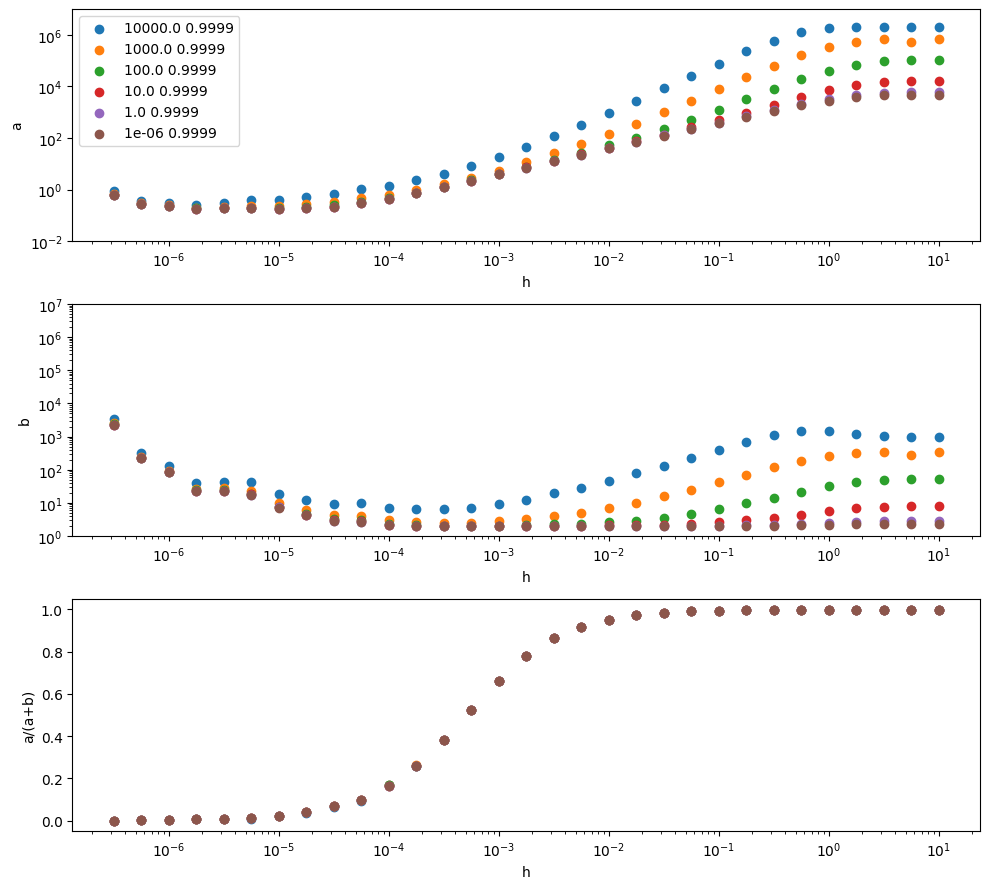

In [31]:
# plot beta parameters for different windows and lambdas from dataframe
fig, axes = plt.subplots(3, 1, figsize=(10, 9))
windows = df["window"].unique()
lambdas = df["lambda"].unique()
hs = df["h"].unique()
# reverse the order of the windows

window=1
lam=0.9999
for window in sorted(windows)[::-1]:
#for lam in lambdas[::4]:
    df_temp = df[(df["window"] == window) & (df["lambda"] == lam)]
    axes[0].scatter(df_temp["h"].values, df_temp["a"], label="{} {}".format(window, lam))
    axes[1].scatter(df_temp["h"].values, df_temp["b"], label="{} {}".format(window, lam))
    axes[2].scatter(df_temp["h"].values, df_temp["a"] / (df_temp["a"]+df_temp["b"]) , label="{} {}".format(window, lam))

axes[0].set_xlabel("h")
axes[1].set_xlabel("h")
axes[2].set_xlabel("h")
axes[0].set_ylabel("a")
axes[1].set_ylabel("b")
axes[2].set_ylabel("a/(a+b)")

axes[0].set_yscale("log")
axes[1].set_yscale("log")
# axes[2].set_yscale("log")

axes[0].set_xscale("log")
axes[1].set_xscale("log")
axes[2].set_xscale("log")

axes[0].set_ylim(1e-2, 1e7)
axes[1].set_ylim(1e0, 1e7)
#axes[2].set_ylim(1e-8, 1e4)

axes[0].legend(loc='upper left')
plt.tight_layout()

Fit the available data with a deep neural network that maps system parameters (h,epsilon) to beta-distribution parameters (a,b)

We follow here the [simple example](https://notebook.community/kit-cel/lecture-examples/mloc/ch3_Deep_Learning/pytorch/function_approximation_with_MLP) using pytorch

Define the model

TODO: In principle we know the $h->0$ and $h->\infty$ solution from the $T->\infty$ solution. Can we make use of this?

Initializing default model (choose own model with kwargs `model`).
DenseNN(
  (act): Tanh()
  (hidden): ModuleList(
    (0): Linear(in_features=3, out_features=42, bias=True)
    (1-2): 2 x Linear(in_features=42, out_features=42, bias=True)
  )
  (output): Linear(in_features=42, out_features=2, bias=True)
)
Next steps:
>> func.set_map() # optimize parameter distribution over activation function domain (input) and range (output) 
>> func.train() # train neural network model
>> func.save(filename) # save function approximation to file
Device for training: mps
Training data with input shape torch.Size([3162, 3]) and output shape torch.Size([3162, 2]).


Training: 100%|██████████| 10000/10000 [00:48<00:00, 207.25it/s]


Training complete; left training mode for faster evaluation! To re-enter training mode call `func.model.train(True)`.


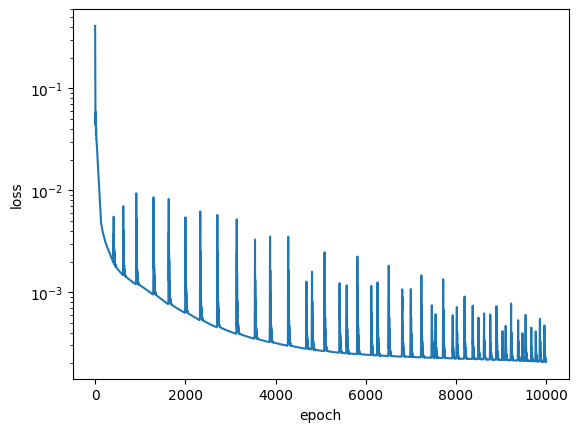

In [37]:
# initialize function approximation
func = FunctionApproximation(verbose=True, input=['lambda', 'window', 'h'], output=['a', 'b'], params=params)
# specify a map from input to NN (inverse not needed)
func.set_map_to_NN('lambda', lambda x: np.log10(1-x))
func.set_map_to_NN('window', lambda x: np.log10(x))
func.set_map_to_NN('h',      lambda x: np.log10(x))
# specify a map from output to NN (for training)
func.set_map_to_NN('a', lambda y: np.log10(y))
func.set_map_to_NN('b', lambda y: np.log10(y))
# specify a map from NN to output (for application)
func.set_map_from_NN('a', lambda Y: 10**Y)
func.set_map_from_NN('b', lambda Y: 10**Y)
## training (takes care of scaling and shuffling)
loss = func.train(df, epochs=10000)
plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.show()
## application
#func([0.9,1,1e-3]) # should return a,b

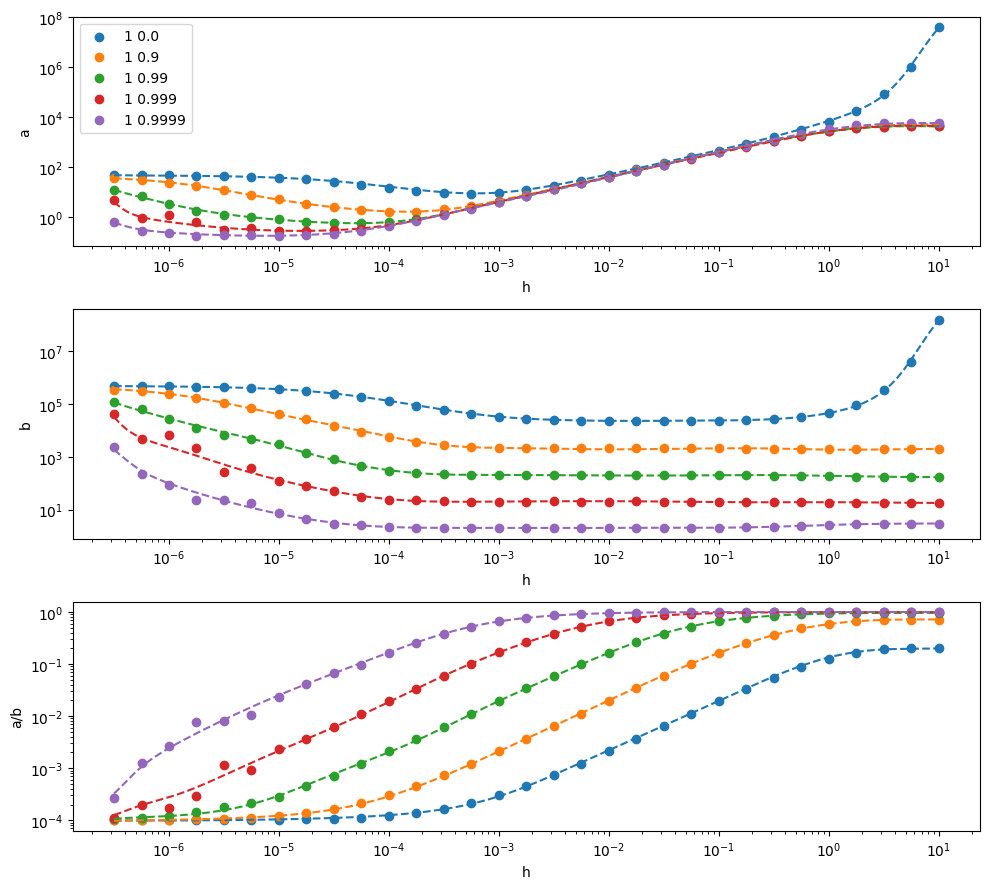

In [38]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1, figsize=(10, 9))

# mesh grid for approximation
hvals = 10**np.linspace(-6.5, 1, 200)

windows = df["window"].unique()
lambdas = np.sort(df["lambda"].unique())
hs = df["h"].unique()

window = 1
# lam=0.9
# for window in sorted(windows)[::-1]:
for lam in lambdas[::4]:
    # load data
    df_temp = df[(df["window"] == window) & (df["lambda"] == lam)]

    # get a,b from function approximation
    avals, bvals = func(lam * np.ones_like(hvals), window * np.ones_like(hvals), hvals)

    ref = axes[0].scatter(
        df_temp["h"].values, df_temp["a"], label="{} {}".format(window, lam)
    )
    axes[0].plot(hvals, avals, color=ref.get_facecolor()[0], linestyle="--")
    axes[1].scatter(
        df_temp["h"].values, df_temp["b"], label="{} {}".format(window, lam)
    )
    axes[1].plot(hvals, bvals, color=ref.get_facecolor()[0], linestyle="--")
    axes[2].scatter(
        df_temp["h"].values,
        df_temp["a"] / (df_temp["a"] + df_temp["b"] ),
        label="{} {}".format(window, lam),
    )
    axes[2].plot(hvals,  avals/ (avals+bvals), color=ref.get_facecolor()[0], linestyle="--")

axes[0].set_xlabel("h")
axes[1].set_xlabel("h")
axes[2].set_xlabel("h")
axes[0].set_ylabel("a")
axes[1].set_ylabel("b")
axes[2].set_ylabel("a/b")

axes[0].set_yscale("log")
axes[1].set_yscale("log")
axes[2].set_yscale("log")

axes[0].set_xscale("log")
axes[1].set_xscale("log")
axes[2].set_xscale("log")

axes[0].legend(loc="upper left")
plt.tight_layout()

### Save function approximation to file

In [39]:
filename = f'./dat/simulation_approximation_seed={seed}.pkl'
func.save(filename=filename)

# test
print(func(0.9,1,1e-3))
test = FunctionApproximation(filename=filename)
print(test(0.9,1,1e-3))

(4.555222, 2163.9846)
(4.555222, 2163.9846)
